### Bedding Example
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook showcases the importance of including bedding angle with the XT3D option for dipping anisotropic layers. 
It also includes a plot of Angle 1 and Angle 2.

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_12556\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [11]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2500, 2500)] #[(2000, 2000), (4000,4000)]
P.xypumpbores = [] #[(2000, 2000), (4000,4000)]
P.idpumpbores = ['P1', 'P2'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (5000,1500)] 
P.zobs = [-40, -50, -100, -200, -300]
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4'] 
P.nobs = len(P.xyobsbores)
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 50000 # 8/5 - was 20000
P.modelmaxtri = 50000 # 8/5 - was 30000
P.angle = 32   # minimum triangle angles
P.nlv  = 50  # 8/5 was 50 - number of layers for voxel transect grid

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 99999

P.geo_bores = ['P1', 'P2', 'P3', 'P4']
P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- GEO MODEL PARAMETERS -----------------------#
#P.fx1, P.fy1, P.fx2, P.fy2 = (2000, 4500, 4000, 2000) # fault end points
P.fx1, P.fy1, P.fx2, P.fy2 = (2000, 4500, 3000, 1000) # fault end points
P.fault_buffer = 150.  # offset boundary from fault

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 3 # Number sublayers for conformable

P.ss = [0.0001, 0.00001, 0.0001, 0.0001]
P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)

### Bedding Angle

{'upper': 0, 'upper_unconformity': 1, 'lower': 2}


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


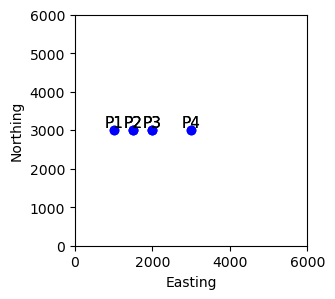

In [12]:
options = [False, True] # XT3D options
P.hk = [5, 100, 1, 1] 
P.vk = [5, 0.1, 0.1, 1]

P.ncol = 60  
P.nrow = 60  
P.nlv  = 50  
P.delx = P.Lx/P.ncol
P.dely = P.Ly/P.nrow

P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False) 
P.control_points = ([]) 
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "bedding_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False) 
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) 

plot_bores(P)
#upper_levels, lower_levels = [-99999, -50, 0, 99999], [-99999, -200, -100, -50, 99999]
#plot_geo_2D_WE(P.geomodel, 1000, upper_levels, lower_levels)
#plot_geo_2D_WE(P.geomodel, 2000, upper_levels, lower_levels)
#plot_geo_2D_WE(P.geomodel, 3000, upper_levels, lower_levels)
#plot_geo_2D_WE(P.geomodel, 4000, upper_levels, lower_levels)

In [13]:
bedding_modelnames = []    
bedding_models = []
bedding_obs_heads = []

for i in range(len(options)):
    bedding_modelnames.append(str('BA_'+str(options[i])))
    bedding_models.append(Model(bedding_modelnames[i], P, plan = 'car', transect = 'vox'))
    P.xt3d = options[i]
    M = bedding_models[i]
    M.create_lith_dis_arrays(P)                                
    M.create_prop_arrays(P)                                     
    M.create_flow_package_arrays(P)                            
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   
    bedding_obs_heads.append((process_obs(P, M)))

Creating lithology and discretisation arrays for  BA_False  ...
Time taken =  4.474675
Creating property arrays for  BA_False  ...
Time taken =  0.113546
Adding flow packages to  BA_False  ...
Time taken =  1.837915
Writing simulation and gwf for  BA_False  ...
BA_False
Running simulation for  BA_False  ...
Period =  Steady 
Model success =  True
run_time =  130.179051
Creating lithology and discretisation arrays for  BA_True  ...
Time taken =  4.243203
Creating property arrays for  BA_True  ...
Time taken =  0.117959
Adding flow packages to  BA_True  ...
Time taken =  2.147541
Writing simulation and gwf for  BA_True  ...
BA_True
Running simulation for  BA_True  ...
Period =  Steady 
Model success =  True
run_time =  1097.977194


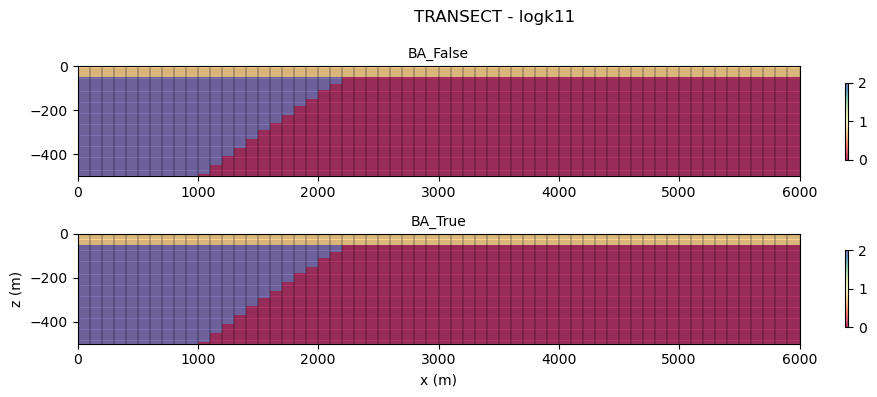

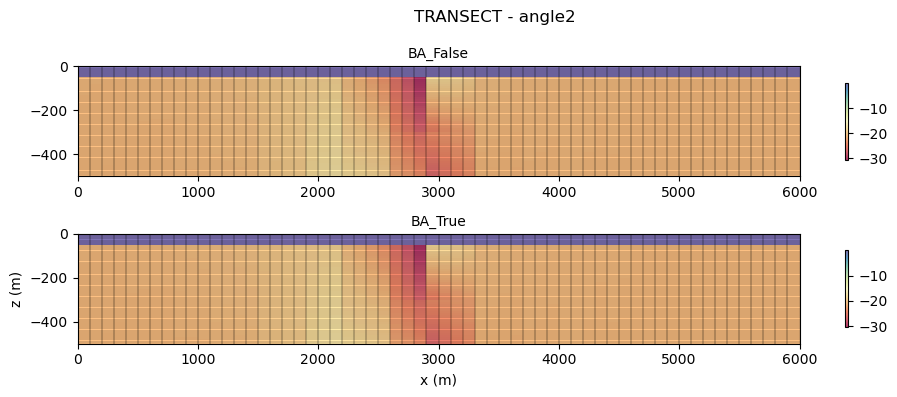

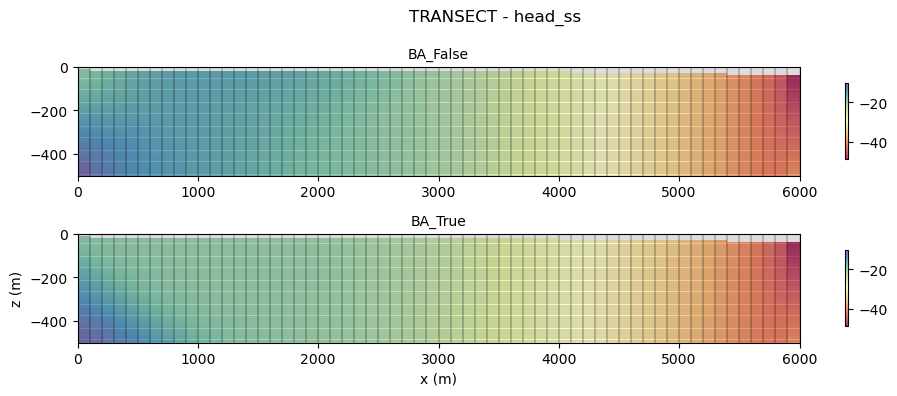

In [14]:
multiplot_prop_transect(P, models = bedding_models, array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
multiplot_prop_transect(P, models = bedding_models, array = 'angle2', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)#vmin = -6, vmax = 0)
multiplot_prop_transect(P, models = bedding_models, array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)#vmin = vmin, vmax = vmax)

In [15]:
levels = np.arange(-40, 0, 2)      
levels

array([-40, -38, -36, -34, -32, -30, -28, -26, -24, -22, -20, -18, -16,
       -14, -12, -10,  -8,  -6,  -4,  -2])

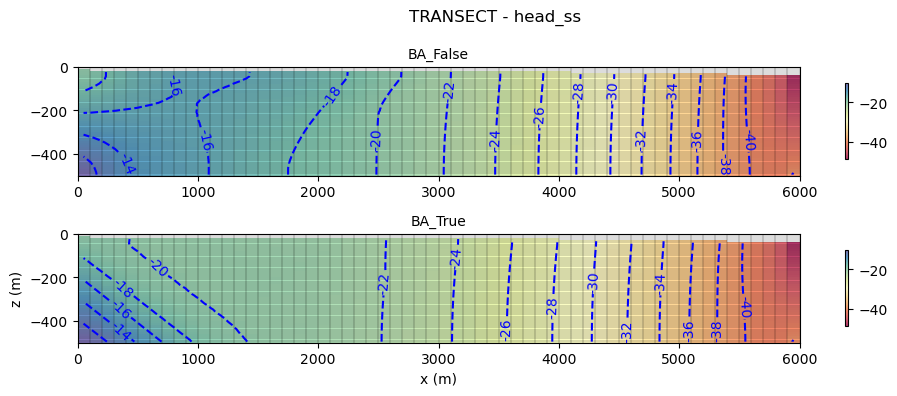

In [16]:
def plot(P, models, array, X0, Y0, X1, Y1, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    nmodels = len(models)
    if nmodels > 1: fig = plt.figure(figsize = (10,2*nmodels))
    if nmodels ==1: fig = plt.figure(figsize = (10,2.5))
    fig.suptitle("TRANSECT - " + array)
    for i in range(nmodels):
        M = models[i]
        model = M.gwf
        a = getattr(M, array)
        
        ax = plt.subplot(nmodels, 1, i+1)
        ax.set_title(M.modelname, size = 10) 
        xsect = flopy.plot.PlotCrossSection(model=model, line={"line": [(X0, Y0),(X1, Y1)]}, 
                                            extent = [P.x0,P.x1,P.z0,P.z1], geographic_coords=True)
        csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
        CS = xsect.contour_array(a = a, colors='Blue', levels = levels)#[-45,-40,-35,-30,-25,-20,-15,-10,-5])
        ax.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')
        #CS = ax.contour(xc, zc, a, levels,colors='Blue', linestyles = 'solid', linewidths=1.0)
        if i == nmodels-1: ax.set_xlabel('x (m)', size = 10)
        if i == int(nmodels/2): ax.set_ylabel('z (m)', size = 10)
        if nmodels>1: linecollection = xsect.plot_grid(lw = 0.1, color = 'black') # Don't plot grid for reference
        plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()    

plot(P, models = bedding_models, array = 'head_ss', X0 = 0, Y0 = 4000, X1 = P.x1, Y1 = 4000)# vmin = 20, vmax = 65)#


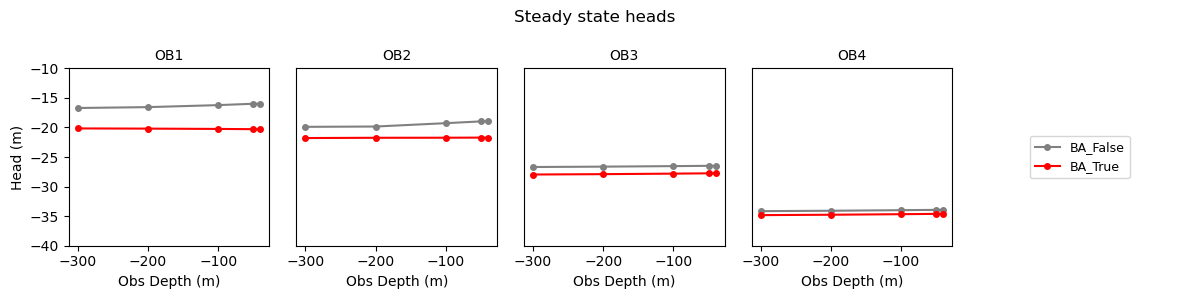

C:\Users\19904604\AppData\Local\Temp\ipykernel_12556\449695775.py:13: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


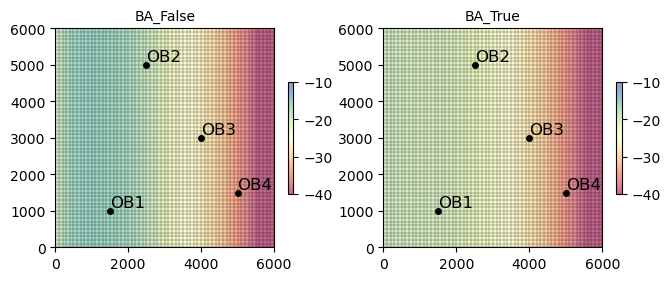

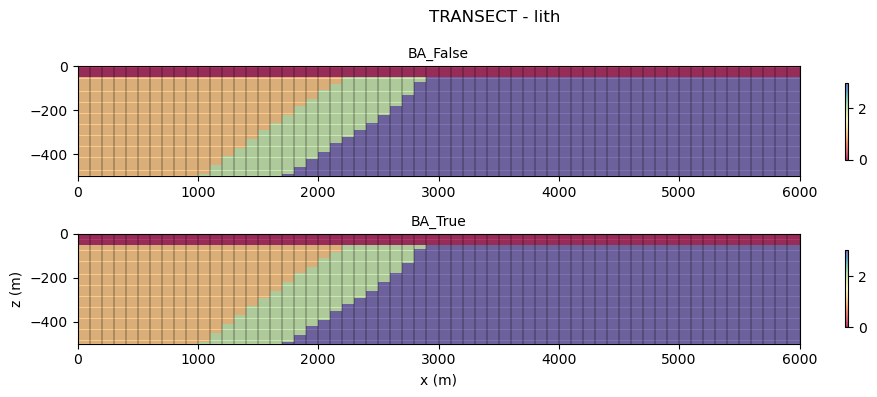

In [17]:
# PLOTS
plot_observations(heads = bedding_obs_heads, modelnames = bedding_modelnames, ylim = [-40, -10])
plot_bylayer(P, models = bedding_models, layer = 4, vmin = -40, vmax = -10) 
multiplot_vgrid_transect(P, models = bedding_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)

### Angle example

In [18]:
# This is a small example which plots Angle 1 and 2
P.hk = [1, 1, 1, 1] 
P.vk = [1, 1, 1, 1]

P.ncol = 30  # was 60
P.nrow = 30  # was 60
P.nlv  = 30  # was 50
P.delx = P.Lx/P.ncol
P.dely = P.Ly/P.nrow

P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False) 
P.control_points = ([]) 
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "angle_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False) 
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) 

M = Model('angle_example', P, plan = 'car', transect = 'vox')
M.create_lith_dis_arrays(P)                                
M.create_prop_arrays(P)                                     
M.create_flow_package_arrays(P)                            
M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  angle_example  ...
Time taken =  1.162887
Creating property arrays for  angle_example  ...
Time taken =  0.022863
Adding flow packages to  angle_example  ...
Time taken =  0.689233
Writing simulation and gwf for  angle_example  ...
angle_example
Running simulation for  angle_example  ...
Period =  Steady 
Model success =  True
run_time =  19.496059


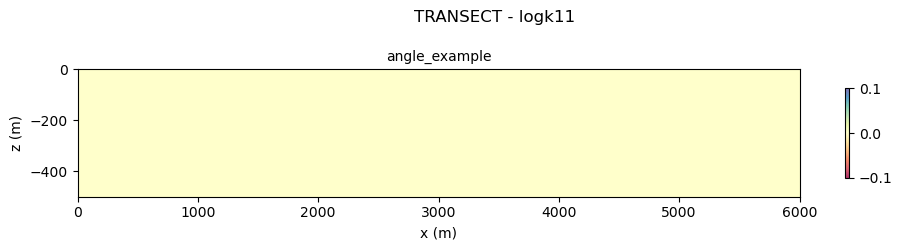

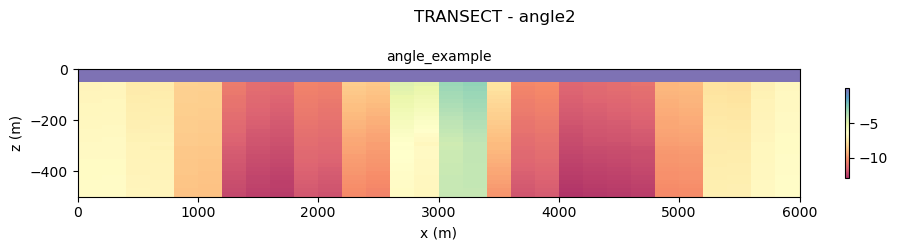

In [19]:
multiplot_prop_transect(P, models = [M], array = 'logk11', X0 = P.x0, Y0 = 3000, X1 = P.x1, Y1 = 3000,)
multiplot_prop_transect(P, models = [M], array = 'angle2', X0 = P.x0, Y0 = 3000, X1 = P.x1, Y1 = 3000,)

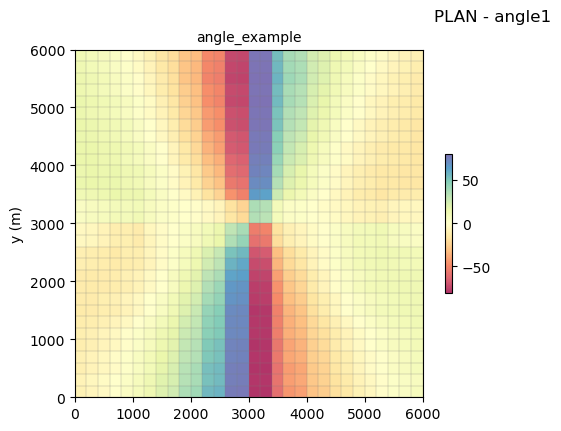

In [20]:
multiplot_prop_plan(P, models = [M], array = 'angle1', layer = 25, vmin = None, vmax = None)

In [21]:
f = os.path.join(vtk_workspace, "angle", M.modelname)
M.gwf.export(f, fmt="vtk")

'vtk_files\\angle\\angle_example'